# Customer Churn Prediction (Modeling)

**Business Context:**  
Customer churn represents a significant revenue risk for telecom companies. Identifying high-risk customers early enables targeted retention strategies, reducing revenue loss and improving customer lifetime value. This notebook leverages predictive modeling to not only identify likely churners but also highlight key drivers of churn and actionable insights for business decision-making.

**Goal of this Notebook:**  
- Prepare and engineer features for modeling, including encoding, scaling, and train/test splitting.  
- Train multiple baseline classification models (Logistic Regression, Random Forest, XGBoost) for comparison.  
- Optimize a **reduced-feature Random Forest model** to prioritize recall while maintaining strong ROC-AUC.  
- Evaluate model performance using metrics such as **accuracy, precision, recall, F1, ROC-AUC**, and visualization (ROC and Precision-Recall curves).  
- Explore the impact of **class imbalance** using SMOTE.  
- Conduct **feature importance analysis** to identify the strongest drivers of churn.  
- Perform **error analysis**, focusing on false negatives to inform targeted retention strategies.  
- Simulate **top-risk customer identification** for actionable business deployment.  
- Translate results into **business insights and recommendations** for proactive churn management.


## 1. Setup

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb



## 2. Load Data
We use the cleaned dataset exported from the EDA notebook (`dataset_part_1_cleaned.csv`).


In [ ]:
df = pd.read_csv("dataset_part_1_cleaned.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Class,TenureBin,EstimatedLifetimeValue,Cluster
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0-12,29.85,1
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,One year,No,Mailed check,56.95,1889.50,0,24-48,1936.30,1
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0-12,107.70,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,24-48,1903.50,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0-12,141.40,1


## 3. Feature Preparation
- Drop redundant features (`customerID`)
- One-hot encode categorical features  
- Scale numeric features

In [ ]:
# Drop identifiers and redundant columns
df = df.drop(columns=['customerID'], errors='ignore')

# Split features and target
X = df.drop(columns=['Class'])
y = df['Class']

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numerical features
scaler = StandardScaler()
num_cols = X_train.select_dtypes(include=['int64','float64']).columns
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("Final shape:", X_train.shape)


Final shape: (5634, 35)


## 4. Baseline Models
We will start with three classifiers:
- Logistic Regression  
- Random Forest  
- Gradient Boosting (XGBoost)

We compare them using ROC-AUC and classification metrics.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [00:33:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


<Figure size 800x600 with 0 Axes>

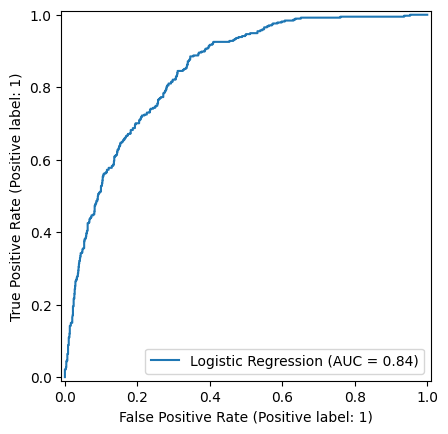

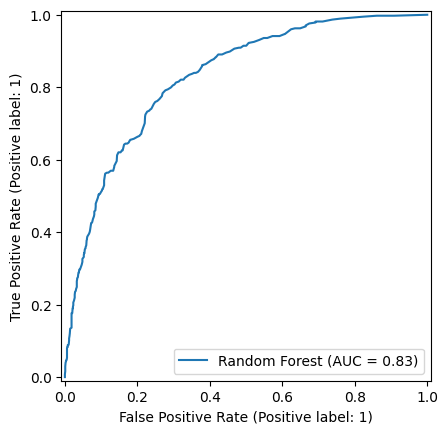

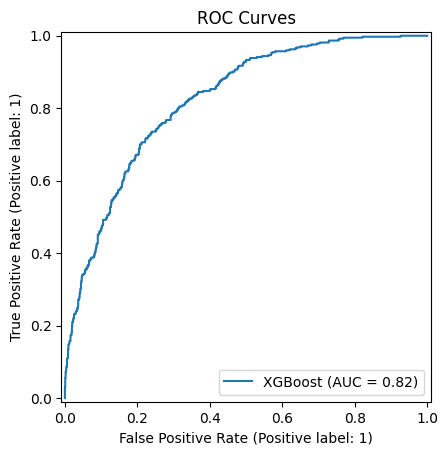

,Accuracy,Precision,Recall,F1,ROC-AUC
Logistic Regression,0.800568,0.655518,0.524064,0.582467,0.844481
Random Forest,0.799148,0.658537,0.505348,0.571861,0.828313
XGBoost,0.779986,0.599379,0.516043,0.554598,0.822738


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    }



# ROC curves
plt.figure(figsize=(8,6))
for name, model in models.items():
    RocCurveDisplay.from_estimator(model, X_test, y_test, name=name)
plt.title("ROC Curves")
plt.show()

# Display results
results_df = pd.DataFrame(results).T
results_df

## 5. Confusion Matrices
Visualize confusion matrices for model interpretability.


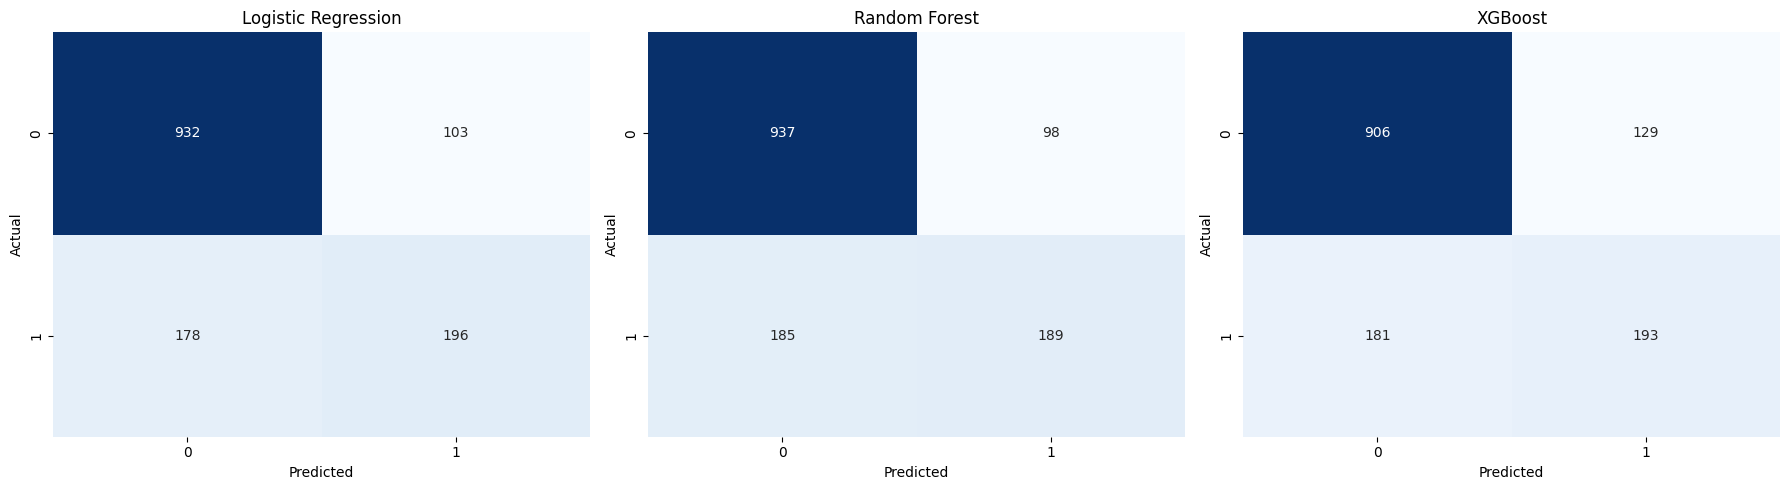

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

## 6. Feature Importance & Selection
We now examine which features are most predictive of churn.
- Use Random Forest feature importances



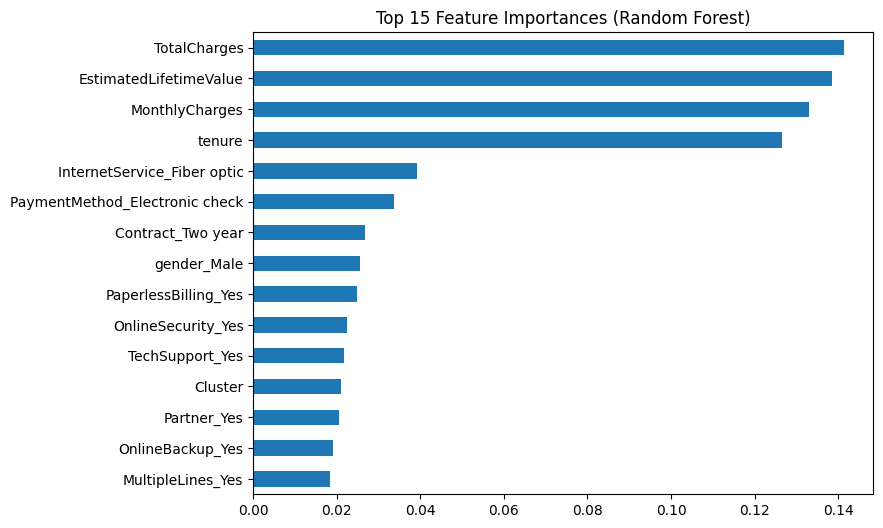

In [ ]:
# Random Forest feature importance
rf = models["Random Forest"]
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
importances[:15].plot(kind='barh')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

## 7. Reduced Feature Model (Tuned + SMOTE)

To simplify deployment and improve interpretability, we retrained the Random Forest model using only the **top 10 most important features** (excluding `TotalCharges`).  

During EDA we found that `TotalCharges` is almost perfectly correlated with `MonthlyCharges × tenure`. Including it can introduce **multicollinearity**, inflate feature importance values, and reduce clarity. Removing it ensures the model focuses on the most **independent and informative drivers of churn**.

### 7.1 Hyperparameter Tuning

To improve recall (our business priority, since missing churners is costlier than flagging false positives), we optimized the reduced-feature Random Forest using **GridSearchCV** with 5-fold cross-validation.  

Parameters tuned:  
- Number of trees (`n_estimators`)  
- Maximum depth (`max_depth`)  
- Minimum samples per split/leaf  
- Class weights (balanced vs. none)

**Best parameters** were chosen based on highest **cross-validation recall**.  
This tuned model serves as the **baseline reduced model** for further analysis.

In [ ]:
# Select top 10 features minus Total charges
top_features = importances[:10].index
X_train_reduced = X_train[top_features].drop(columns = ['TotalCharges'])
X_test_reduced = X_test[top_features].drop(columns = ['TotalCharges'])

from sklearn.model_selection import GridSearchCV

# GridSearch for reduced-feature Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

grid_rf.fit(X_train_reduced, y_train)

print("Best params:", grid_rf.best_params_)
print("Best CV recall:", grid_rf.best_score_)

Best params: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV recall: 0.7933110367892977


### 7.2 Performance of the Reduced Feature RF

In [ ]:
# Use the best estimator for evaluation
reduced_model = grid_rf.best_estimator_


y_pred_reduced = reduced_model.predict(X_test_reduced)
y_proba_reduced = reduced_model.predict_proba(X_test_reduced)[:,1]

# Compile metrics into a dictionary
reduced_metrics = {
    "Accuracy": [accuracy_score(y_test, y_pred_reduced)],
    "Precision": [precision_score(y_test, y_pred_reduced)],
    "Recall": [recall_score(y_test, y_pred_reduced)],
    "F1": [f1_score(y_test, y_pred_reduced)],
    "ROC-AUC": [roc_auc_score(y_test, y_proba_reduced)]
}

# Convert to DataFrame
reduced_metrics_df = pd.DataFrame(reduced_metrics, index=["Reduced Feature RF"])

# Combine into a single DataFrame for comparison
comparison_df = pd.concat([results_df, reduced_metrics_df], ignore_index=False)

| Model | Accuracy | Precision | Recall | F1 | ROC-AUC |
|-------|----------|-----------|--------|----|---------|
| Logistic Regression | 0.801 | 0.656 | 0.524 | 0.582 | 0.844 |
| Random Forest | 0.799 | 0.659 | 0.505 | 0.572 | 0.828 |
| XGBoost | 0.780 | 0.599 | 0.516 | 0.555 | 0.823 |
| **Reduced RF (tuned)** | 0.735 | 0.500 | **0.789** | 0.612 | 0.839 |

**Key Insight:**  
- The reduced-feature RF trades some **accuracy/precision** for **higher recall** (0.79), which aligns with the business goal of catching more churners.  
- Despite using fewer features, it achieves **competitive ROC-AUC (0.839)**, showing strong overall ranking ability.  
- This makes it a strong candidate for deployment.


### 7.3 Class Imbalance: SMOTE

Since churn is imbalanced (~27% churn vs. 73% retained), we also tested **SMOTE oversampling** to balance classes during training.

In [ ]:
# Oversample minority class using SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_reduced, y_train)

# Then fit your reduced_model on X_train_bal, y_train_bal
reduced_model.fit(X_train_bal, y_train_bal)

y_pred_smote = reduced_model.predict(X_test_reduced)
y_proba_smote = reduced_model.predict_proba(X_test_reduced)[:,1]

# Compile metrics into a dictionary
smote_metrics = {
    "Accuracy": [accuracy_score(y_test, y_pred_smote)],
    "Precision": [precision_score(y_test, y_pred_smote)],
    "Recall": [recall_score(y_test, y_pred_smote)],
    "F1": [f1_score(y_test, y_pred_smote)],
    "ROC-AUC": [roc_auc_score(y_test, y_proba_smote)]
}

# Convert to DataFrame
smote_metrics_df = pd.DataFrame(smote_metrics, index=["Reduced Feature RF (with SMOTE)"])

# Combine into a single DataFrame for comparison
smote_comparison_df = pd.concat([reduced_metrics_df, smote_metrics_df], ignore_index=False)

| Model | Accuracy | Precision | Recall | F1 | ROC-AUC |
|-------|----------|-----------|--------|----|---------|
| Reduced RF (tuned) | 0.735 | 0.500 | 0.789 | 0.612 | 0.839 |
| Reduced RF (tuned + SMOTE) | 0.729 | 0.493 | 0.791 | 0.608 | 0.837 |

**Key Insight:**  
- SMOTE slightly improves recall but at the cost of reduced accuracy and precision.  
- Since recall is already strong without oversampling, and SMOTE adds training complexity, the **non-SMOTE tuned model** is preferred for deployment.  

### 7.4 Feature Importance

/tmp/ipython-input-4194083326.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp, x="Importance", y="Feature", palette="viridis")


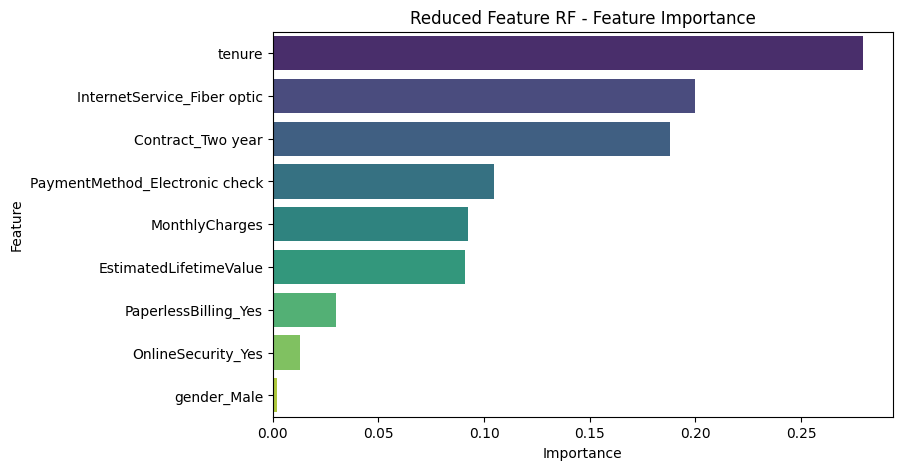

In [ ]:
# Feature importance plot
importances = reduced_model.feature_importances_
feat_names = X_train_reduced.columns

feat_imp = pd.DataFrame({"Feature": feat_names, "Importance": importances})
feat_imp = feat_imp.sort_values("Importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=feat_imp, x="Importance", y="Feature", palette="viridis")
plt.title("Reduced Feature RF - Feature Importance")
plt.show()

**Key Insights:**

- **Tenure** is the strongest churn driver — customers with **shorter relationships** are most likely to leave.  
- **InternetService_Fiber optic** customers show **higher churn risk**, consistent with possible dissatisfaction or competition.  
- **Two-year contracts** strongly **reduce churn**, confirming that longer commitments protect retention.  
- **Electronic check payments** are linked to **elevated churn**, reflecting billing-related friction.  
- **MonthlyCharges** and **EstimatedLifetimeValue** contribute meaningfully but are **secondary** compared to tenure, service type, and contract length.  
- These results align with the **EDA findings**, strengthening confidence in the model’s interpretation of churn drivers.

### 7.5 ROC & Precision–Recall Curves

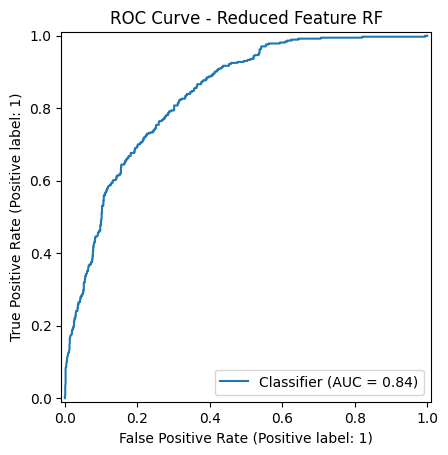

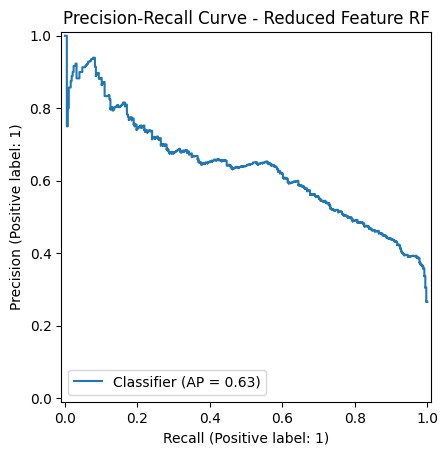

In [ ]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

y_proba = reduced_model.predict_proba(X_test_reduced)[:,1]

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve - Reduced Feature RF")
plt.show()

# Precision-Recall curve
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title("Precision-Recall Curve - Reduced Feature RF")
plt.show()


- **ROC Curve:** The reduced RF achieves a ROC-AUC of 0.839, confirming strong discriminative ability.  
- **PR Curve:** Precision falls as recall increases, but the curve stays well above the baseline (churn prevalence ≈ 27%).  
- **Business implication:** By adjusting the probability threshold, stakeholders can **prioritize recall (catching churners)** or **precision (minimizing false positives)** depending on campaign budget.

### 7.6 Summary

The **tuned reduced-feature Random Forest** offers:  
- **High recall (0.79):** captures most at-risk customers  
- **Competitive AUC (0.839):** good ranking performance  
- **Fewer features (10 vs. full set):** easier to interpret, faster to deploy  
- **Alignment with EDA findings:** confirms key churn drivers like contract type, payment method, and charges  

This makes it the **recommended deployment model**, balancing predictive power with interpretability and operational feasibility.

## 8. Error Analysis: False Negatives

**Purpose:**  
False negatives are customers who **actually churned (y_test = 1)** but were **predicted as retained** by the model. Understanding these cases helps target retention strategies more effectively.

We focus on the **reduced-feature Random Forest model**, since this is the model planned for deployment.

### 8.1 Identify False Negatives

In [ ]:
# Predictions
y_pred_reduced = reduced_model.predict(X_test_reduced)

# Boolean index for false negatives
false_negatives_idx = (y_test == 1) & (y_pred_reduced == 0)

# Subset of features for false negatives
fn_customers = X_test_reduced[false_negatives_idx]

### 8.2 Summary of Numeric Features

In [ ]:
# Numeric summary
fn_numeric_summary = fn_customers.describe().T

**False negatives:** 78 customers who actually churned but were predicted as retained by the reduced-feature Random Forest.

| Feature | Mean (scaled) | Std Dev | Median | Notes |
|---------|---------------|---------|--------|-------|
| EstimatedLifetimeValue | 0.057 | 1.08 | -0.337 | Most missed churners have **around-average lifetime value**, but some high-value customers (max ≈ 2.54) are being missed — these could be costly if lost. |
| MonthlyCharges | -0.117 | 0.98 | -0.247 | Most false negatives are slightly below average in monthly charges, though a small tail of higher charges exists (max ≈ 1.68). |
| tenure | -0.061 | 0.94 | -0.223 | These customers tend to have **shorter tenure**, consistent with higher churn risk. |

**Business Interpretation:**  
- The majority of false negatives are **short-tenure customers**, who are generally at higher risk of churn.  
- A few **high-value customers** are missed; prioritizing them in retention campaigns could protect significant revenue.  
- Overall, the reduced-feature model captures most churn patterns but misses a **small subset of potentially important customers**, highlighting areas for targeted intervention.


### 8.3 Analysis of Categorical/Binary Features

In [ ]:
# Summarize binary/categorical features
binary_features = [
    'InternetService_Fiber optic', 'PaymentMethod_Electronic check',
    'Contract_Two year', 'gender_Male', 'PaperlessBilling_Yes', 'OnlineSecurity_Yes'
]

fn_binary_summary = fn_customers[binary_features].mean().sort_values(ascending=False)

We examine the distribution of key categorical/binary features among customers that the reduced-feature Random Forest **predicted as retained but actually churned**.

| Feature | Proportion of False Negatives | Interpretation |
|---------|-------------------------------|----------------|
| PaperlessBilling_Yes | 0.577 | ~58% of false negatives use paperless billing. |
| gender_Male | 0.423 | ~42% are male — gender is less predictive in this subset. |
| OnlineSecurity_Yes | 0.346 | ~35% have online security, indicating moderate coverage of this segment. |
| InternetService_Fiber optic | 0.269 | ~27% use fiber optic internet — a known higher-risk service. |
| PaymentMethod_Electronic check | 0.192 | ~19% pay via electronic check — aligns with known elevated churn risk. |
| Contract_Two year | 0.115 | Only ~12% are on a two-year contract — majority are short-term, consistent with higher churn. |

**Insights:**  
- Most false negatives are **short-term contract holders**, reinforcing that tenure and contract type are key churn drivers.  
- Paperless billing remains prevalent among missed churners, suggesting moderate risk.  
- Fiber optic internet and electronic check payment users contribute to missed churn predictions, consistent with earlier EDA findings.  
- Gender and online security status have limited influence on false negatives but provide additional context for targeting interventions.

### 8.4 Key Takeaways for Business

- **Short-tenure customers** are the largest segment of false negatives — these at-risk, newer customers should be prioritized for retention efforts.  

- A **small subset of high-value customers** (high EstimatedLifetimeValue) are still being missed; losing these customers could have a significant financial impact, so targeted retention for this group is crucial.  

- **Paperless billing users, fiber optic internet subscribers, and electronic check payers** appear more frequently among false negatives, suggesting these groups may need additional attention even if the model predicts retention.  

- Overall, false negatives highlight **gaps in the model**, providing actionable guidance for designing retention campaigns that focus on the most at-risk and high-impact customer segments.


## 9. Deployment Simulation: Identifying High-Risk Customers

To demonstrate how the reduced-feature Random Forest model could be applied in a business context, we simulate a deployment scenario by identifying customers with the highest predicted probability of churn.

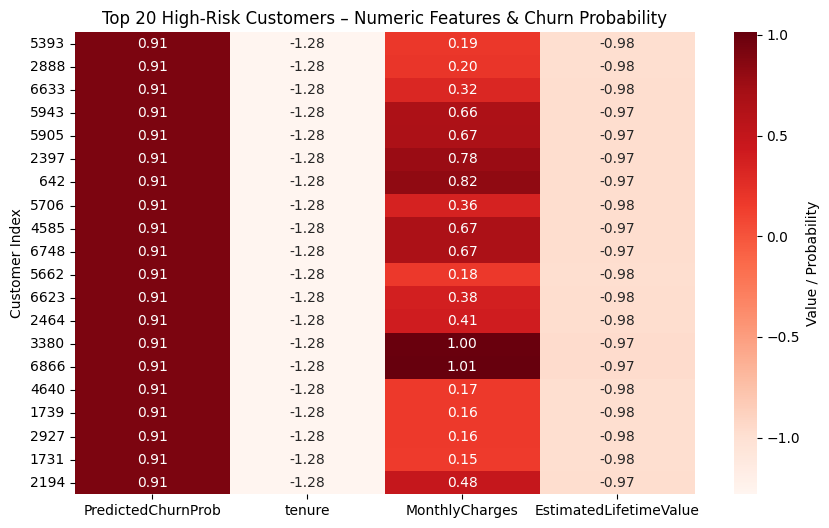

In [ ]:
# Predict churn probabilities for test set
pred_probs = reduced_model.predict_proba(X_test_reduced)[:,1]

# Identify top 20 highest-risk customers
top_risk_idx = np.argsort(pred_probs)[-20:]
top_risk_customers = X_test_reduced.iloc[top_risk_idx].copy()
top_risk_customers['PredictedChurnProb'] = pred_probs[top_risk_idx]

# Sort by predicted probability
top_risk_customers.sort_values('PredictedChurnProb', ascending=False)

numeric_cols = ['PredictedChurnProb', 'tenure', 'MonthlyCharges', 'EstimatedLifetimeValue']
top_risk_numeric = top_risk_customers[numeric_cols]

plt.figure(figsize=(10,6))
sns.heatmap(top_risk_numeric, annot=True, fmt=".2f", cmap="Reds", cbar_kws={'label': 'Value / Probability'})
plt.title("Top 20 High-Risk Customers – Numeric Features & Churn Probability")
plt.ylabel("Customer Index")
plt.show()


### Top 20 High-Risk Customers – Key Insights

- **Extremely low tenure:**  
  All top 20 customers have a scaled tenure of approximately `-1.28`, indicating they are **very new customers**. This aligns with earlier findings that **short-tenure customers are at the highest risk of churn**.

- **Moderate Monthly Charges:**  
  Most of these customers have **below-average to slightly above-average monthly charges**, with a few high outliers (e.g., ~1.0 scaled). This suggests that **both low- and moderate-paying new customers are vulnerable**, while high-paying new customers may require targeted retention to protect revenue.

- **Low Estimated Lifetime Value:**  
  Scaled EstimatedLifetimeValue ranges from ~`-0.98` to `-0.96`, showing that these high-risk customers generally **have low accumulated revenue so far**. However, a few customers have slightly higher lifetime value, meaning **retaining even a small subset could yield meaningful financial benefit**.

- **Predicted churn probability:**  
  All top 20 customers have **predicted churn probabilities above ~0.90**, reflecting strong model confidence that these customers are at imminent risk.

**Business Interpretation:**  

- **Focus retention efforts on new customers:** Short-tenure customers dominate the high-risk group; proactive retention programs (e.g., onboarding support, introductory discounts) could significantly reduce early churn.  

- **High-value new customers:** While most have low accumulated value, a few high MonthlyCharges or higher EstimatedLifetimeValue customers should be **prioritized for personalized retention campaigns**, as their loss would be more costly.  

- **Actionable targeting:** Combining predicted churn probability with tenure, charges, and lifetime value allows the business to **segment interventions by urgency and potential financial impact**, optimizing retention resource allocation.

## 10. Business Insights

By integrating **EDA findings**, **reduced-feature model results**, and **top-risk customer analysis**, we can provide actionable recommendations:

- **EDA-driven insights:**
  - Customers on **month-to-month contracts** continue to exhibit the highest churn → target them with loyalty programs, onboarding support, or retention offers.
  - Customers using **electronic check payments** are higher-risk → encourage more stable payment methods (automatic credit card or bank transfer).
  - **Fiber optic internet users** have elevated churn risk → consider tailored service engagement or bundled promotions.

- **Model-driven insights (Reduced-Feature Random Forest):**
  - **Top predictors of churn:** `tenure`, `InternetService_Fiber optic`, `Contract_Two year` (protective), `PaymentMethod_Electronic check`, `MonthlyCharges`, and `EstimatedLifetimeValue`.  
    - **Tenure:** Short-tenure customers dominate the high-risk group → prioritize onboarding and early retention interventions.  
    - **Contract type:** Long-term contracts are protective; customers without them are higher-risk.  
    - **Charges & Lifetime Value:** While most high-risk customers have low accumulated value, a few high-value new customers require focused retention to prevent financial loss.  
  - **Paperless billing** and **online security status** provide additional context but are less influential individually.
  - **SMOTE vs. no SMOTE:** Minimal difference in recall and ROC-AUC, suggesting the model is robust to class imbalance with current preprocessing.

- **Deployment/Targeting insights:**
  - **Top 20 high-risk customers** have extremely low tenure and predicted churn probabilities >0.90 → immediate retention action recommended.
  - Segment retention campaigns by **risk level, tenure, and potential financial impact**, ensuring high-value customers are prioritized.


## 11. Conclusion

- **Baseline model performance:**  
  - Logistic Regression: **ROC-AUC ≈ 0.844**, Recall ≈ 0.524.  
  - Random Forest: ROC-AUC ≈ 0.828, Recall ≈ 0.505.  
  - XGBoost: ROC-AUC ≈ 0.823, Recall ≈ 0.516.  
  - Models are reasonably consistent, with Logistic Regression slightly outperforming others on recall.

- **Reduced-feature Random Forest (tuned):**  
  - **Recall ≈ 0.789**, ROC-AUC ≈ 0.839 → significantly improved recall compared to baseline RF, making it **well-suited for identifying churners**.  
  - Benefits: simpler, interpretable, less multicollinearity, faster training and deployment.

- **Key drivers of churn:**  
  - **Numeric & engineered features:** `tenure`, `MonthlyCharges`, `EstimatedLifetimeValue`.  
  - **Categorical features:** `InternetService_Fiber optic`, `Contract_Two year` (protective), `PaymentMethod_Electronic check`.  
  - Insights are consistent with EDA, reinforcing confidence in the model’s predictive power.

- **Business impact considerations:**  
  - Prioritize **high recall**, as missing churners is costlier than false positives.  
  - Targeted retention should focus on **short-tenure customers**, **electronic check users**, and **high-value at-risk customers**.  
  - Trade-offs between recall and precision must be evaluated if retention costs are significant.

- **Next steps:**  
  - Deploy the reduced-feature RF model in a **real-time churn dashboard or API**.  
  - Monitor **early churn signals for new customers** and high-value segments.  
  - Periodically retrain the model with **updated data** to capture shifts in customer behavior.  
  - Consider **personalized retention strategies** using top-risk predictions combined with customer segmentation.

## 12. Model Saving and Deployment Readiness

To complete the end-to-end workflow, we save the final **Reduced-Feature Random Forest** model.  
This ensures the model can be loaded and applied directly to new customer data in production (e.g., churn dashboards, APIs) without retraining.

In [ ]:
import joblib

# Save the trained model
joblib.dump(reduced_model, "reduced_rf_churn_model.pkl")

# Load the model back
loaded_model = joblib.load("reduced_rf_churn_model.pkl")

# Quick test: predict on a few customers
sample_preds = loaded_model.predict(X_test_reduced.iloc[:5])
sample_probs = loaded_model.predict_proba(X_test_reduced.iloc[:5])[:,1]

print("Sample Predictions:", sample_preds)
print("Sample Churn Probabilities:", sample_probs)

Sample Predictions: [0 1 0 1 0]
Sample Churn Probabilities: [0.0680418  0.8054621  0.24585371 0.6834983  0.0319385 ]


**Key Takeaway:**  
- Section 9 demonstrated **how the model’s outputs can drive retention actions** (identifying top-risk customers).  
- Saving the model ensures it can be **deployed consistently in real-time systems**, making churn prevention actionable at scale.  